In [1]:
import sys, os
import xarray as xr
import numpy as np
import biometeo

from mrt_utils import *
from tqdm import tqdm

import importlib
import biometeo_parallel
from multiprocessing import cpu_count


In [2]:

exp_name = 'OUT_v6teb_ICONfixed2ERA5_AEV5t2_alb2_rt25_noconv_rucpOVMr2_thDS'

if os.name == 'nt':
    ds_dir = fr"G:\!Data\Moscow\CLM\Experiments\Short_runs_MSK\20210601\MSK_0.0025_WorldCover1_rucpOVMr2\{exp_name}\cr\\"
else:
    ds_dir = f'/home/mvarentsov/data/COSMO/MSK/20210601/MSK_0.0025_WorldCover1_rucpOVMr2/{exp_name}/cr/'

ds = xr.open_mfdataset(ds_dir + '*.nc')
#ds.load()



In [3]:
ground_alb  = 0.2
ground_emis = 0.95
ground_z0 = 0.1
ground_z0_utci=0.01

ds['VEL_10M'] = np.sqrt (ds['U_10M']**2 + ds['V_10M']**2)
ds['GHI'] = ds['SWDIRS_RAD'] + ds['SWDIFDS_RAD']

if 'MRT_sun' not in ds.data_vars or 'MRT_shd' not in ds.data_vars:
    ds['MRT_sun'],ds['MRT_shd'] = calc_MRT4ds (ds, 'T_2M', 'GHI', 'SWDIFDS_RAD', 'THDS_RAD', 'T_G', ground_alb, ground_emis)
    ds['MRT_sun'].to_netcdf(ds_dir + 'MRT_sun.nc')
    ds['MRT_shd'].to_netcdf(ds_dir + 'MRT_shd.nc')

ds['T_2Mc'] = ds['T_2M'] - 273.15
ds['E_2M'] = 6.11 * np.exp(17.27 * ds['T_2Mc'] / (ds['T_2Mc'] + 237.3))
ds['e_2M'] = ds['E_2M'] * ds['RELHUM_2M'] / 100

# Compute wind speed at 1.1m with bounds
ds['VEL_1.1m'] = ds['VEL_10M'] * np.log(1.1/ground_z0) / np.log(10/ground_z0)
ds['VEL_10M4UTCI'] = ds['VEL_1.1m'] * np.log(10/ground_z0_utci) / np.log(1.1/ground_z0_utci)
ds['VEL_1.1m4UTCI'] = ds['VEL_10M4UTCI'] * np.log(1.1/ground_z0_utci) / np.log(10/ground_z0_utci)
ds['VEL_1.1m'] = ds['VEL_1.1m'].clip(min=0.35, max=7.9) #for biometeo UTCI
ds['VEL_10M4UTCI'] = ds['VEL_10M4UTCI'].clip(min=0.5, max=17.5) #for biometeo UTCI

# Convert MRT to Celsius
ds['MRT_sun_C'] = ds['MRT_sun'] - 273.15
ds['MRT_shd_C'] = ds['MRT_shd'] - 273.15

In [5]:

importlib.reload(biometeo_parallel)

ds_sel = ds.isel(rlon=slice(0,2), rlat=slice(0,2))

n_jobs = 1

ds_sel['PET_sun_biomet']  = biometeo_parallel.compute4xarray_ds ('biometeo.PET', ds_sel, {'Ta':'T_2Mc', 'v':'VEL_1.1m', 'VP':'e_2M', 'Tmrt':'MRT_sun_C'}, n_jobs, result_key='PET_v', n_chunks=361, use_tqdm = True, tqdm_desc='PET_sun_biomet')
ds_sel['PET_shd_biomet']  = biometeo_parallel.compute4xarray_ds ('biometeo.PET', ds_sel, {'Ta':'T_2Mc', 'v':'VEL_1.1m', 'VP':'e_2M', 'Tmrt':'MRT_shd_C'}, n_jobs, result_key='PET_v', n_chunks=361, use_tqdm = True, tqdm_desc='PET_shd_biomet')

ds_sel['UTCI_sun_bimet'] = biometeo_parallel.compute4xarray_ds ('biometeo.UTCI', ds_sel, {'Ta':'T_2Mc', 'v':'VEL_1.1m', 'VP':'e_2M', 'Tmrt':'MRT_sun_C'}, n_jobs, n_chunks=361, use_tqdm = True, tqdm_desc='UTCI_sun_bimet')
ds_sel['UTCI_shd_bimet'] = biometeo_parallel.compute4xarray_ds ('biometeo.UTCI', ds_sel, {'Ta':'T_2Mc', 'v':'VEL_1.1m', 'VP':'e_2M', 'Tmrt':'MRT_shd_C'}, n_jobs, n_chunks=361, use_tqdm = True, tqdm_desc='UTCI_shd_bimet')

ds_sel['PET_sun_pythc']  = biometeo_parallel.compute4xarray_ds ('pythermalcomfort.models.pet_steady.pet_steady', ds_sel,  {'tdb':'T_2Mc', 'v':'VEL_10M4UTCI', 'rh':'RELHUM_2M', 'tr':'MRT_sun_C'}, n_jobs, result_key='pet', n_chunks=361, use_tqdm = True, static_params={'met': 1.37, 'clo': 0.9, 'position':'standing', 'age': 35}, tqdm_desc='PET_sun_pythc')
ds_sel['PET_shd_pythc']  = biometeo_parallel.compute4xarray_ds ('pythermalcomfort.models.pet_steady.pet_steady', ds_sel,  {'tdb':'T_2Mc', 'v':'VEL_10M4UTCI', 'rh':'RELHUM_2M', 'tr':'MRT_shd_C'}, n_jobs, result_key='pet', n_chunks=361, use_tqdm = True, static_params={'met': 1.37, 'clo': 0.9, 'position':'standing', 'age': 35}, tqdm_desc='PET_shd_pythc')

ds_sel['UTCI_sun_pythc'] = biometeo_parallel.compute4xarray_ds ('pythermalcomfort.models.utci', ds_sel, {'tdb':'T_2Mc', 'v':'VEL_10M4UTCI', 'rh':'RELHUM_2M', 'tr':'MRT_sun_C'}, n_jobs, result_key='utci', n_chunks=361, use_tqdm = True, tqdm_desc='UTCI_sun_pythc')
ds_sel['UTCI_shd_pythc'] = biometeo_parallel.compute4xarray_ds ('pythermalcomfort.models.utci', ds_sel, {'tdb':'T_2Mc', 'v':'VEL_10M4UTCI', 'rh':'RELHUM_2M', 'tr':'MRT_shd_C'}, n_jobs, result_key='utci', n_chunks=361, use_tqdm = True, tqdm_desc='UTCI_shd_pythc')


UTCI_shd_pythc: 100%|██████████| 361/361 [00:00<00:00, 3101.67it/s]


In [ ]:
# ds_sel['PET_sun'].to_netcdf(ds_dir + 'PET_sun.nc')
# ds_sel['PET_shd'].to_netcdf(ds_dir + 'PET_shd.nc')
# ds_sel['UTCI_sun'].to_netcdf(ds_dir + 'UTCI_sun.nc')
# ds_sel['UTCI_shd'].to_netcdf(ds_dir + 'UTCI_shd.nc')

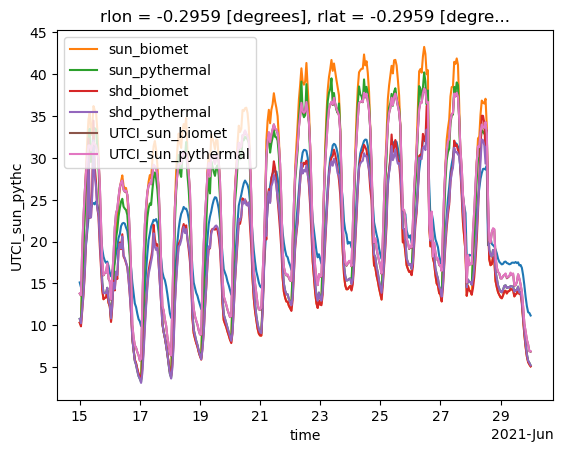

In [8]:
from matplotlib import pyplot as plt

ds4point = ds_sel.isel(rlon=1, rlat=1)
(ds4point['T_2M']-273.5).plot()
#ds4point['PET_sun'].plot()
#ds4point['PET_shd'].plot()

ds4point['PET_sun_biomet'].plot(label='sun_biomet')
ds4point['PET_sun_pythc'].plot(label='sun_pythermal')

ds4point['PET_shd_biomet'].plot(label='shd_biomet')
ds4point['PET_shd_pythc'].plot(label='shd_pythermal')

ds4point['UTCI_sun_bimet'].plot(label='UTCI_sun_biomet')
ds4point['UTCI_sun_pythc'].plot(label='UTCI_sun_pythermal')


#ds4point['UTCI_shd'].plot()

plt.legend()

In [117]:
module.VP_RH_exchange(RH=50,Ta=25)

{'VP': np.float64(15.810119845429861)}